In [1]:
# API KEY Loading
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH21-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-LangGraph


# LangGraph Agent, Memory 추가 

- 개발하고 있는 챗봇은 과거 상호작용을 스스로 기억할 수 없어 일관된 멀티턴 대화를 진행하는데 제한
- 이를 해결하기 위해 **memory** 추가
- LangGraph에 pre-built 되어 있는 `ToolNode` 와 `tools_condition` 활용

1. [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode): 도구 호출을 위한 노드
2. [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.tools_condition): 도구 호출 여부에 따른 조건 분기

## Checkpointer 생성 

- 그래프를 컴파일할 때 `checkpointer`를 제공하고 그래프를 호출할 때 `thread_id`를 제공하면, `LangGraph`는 각 단계 후 **상태를 자동으로 저장**  
    - 그래프 실행 중 생성된 모든 state가 thread_id 기준으로 전부 저장
    - state에 포함되는 기본 정보 
        - messages : 대화 히스토리 (HumanMassage, AIMessage, ToolMessage 등)
        - tool 결과 : 도구 호출 결과, 파라미터 등 
        - memory 정보 : memory 상태정보 
        
- 동일한 `thread_id`를 사용하여 그래프를 다시 호출하면, 그래프는 저장된 상태를 로드하여 챗봇이 이전에 중단한 지점에서 대화를 이어갈 수 있음

<img src="./temp/memory_structure.png" width="500"/>

- [참고]
    - 해당 노트북 파일에서는 in-memory checkpointer 사용 
        - 인메모리에 저장되므로 세션이 종료되면 사라짐 
        - 저장 용량은 사용 중인 메모리에 따라 제한 (보통 수천 개 메시지도 가능하지만, 너무 많으면 느려짐) 
    - 프로덕션에서는 DB 연결 필요 (SqliteSaver, PostgresSaver, 자체 DB 등)
        - 저장 용량은 디스크 용량과 DB 설정에 따라 적용 
        - 대규모 state 기록이 가능하며, 장기 보존 및 분석에도 활용 가능 
        - 다만, 저장되는 state가 너무 크면 읽기/쓰기 성능에 영향 있음

In [3]:
from langgraph.checkpoint.memory import MemorySaver

In [4]:
# 메모리 저장소 생성
memory = MemorySaver()

## Graph

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

- ToolNode : 여러 도구(함수)를 실행할 수 있게 해주는 노드 클래스 
    - 일반적으로 tool_calls 메시지가 포함된 상태가 들어오면, 
    - 해당 ToolNode는 해당 도구를 찾아 실행하고, 그 결과를 메시지로 반환 
- tools_condition : LLM 응답 중 도구 호출 요청이 있는지를 확인하는 조건 함수 (conditional function) 
    - 입력 : state 객체 
    - 조건 : state["messages"][-1]에 tool_calls_가 존재하는가? 
    - 반환 
        - True : 도구 호출 필요 
        - False : 도구 호출 없음 

In [6]:
########## 1. State ##########
class State(TypedDict):
    messages: Annotated[list, add_messages]


# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


########## 3. NODE ##########
# 챗봇 함수 정의
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# Graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)


########## 4. EDGE ##########
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [7]:
# Compile
graph = graph_builder.compile(checkpointer=memory)

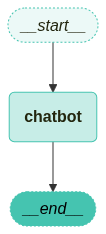

In [8]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

[그래프 해석] 

- __start__ → chatbot : 실선 (기본 흐름)
- chatbot → __end__   : 점선 (조건부 분기)
- chatbot → tools     : 점선 (조건부 분기)
- tools → chatbot     : 실선 (기본 흐름)

## RunnableConfig

- `recursion_limit`: 최대 방문할 노드 수. 그 이상은 RecursionError 발생
- `thread_id`: 스레드 ID 설정. 대화 세션을 구분. 메모리의 저장은 `thread_id` 에 따라 개별적으로 이루어짐

In [9]:
from langchain_core.runnables import RunnableConfig

In [10]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "001"})

In [11]:
# 첫번째 질문
question = "내 이름은 김영희 입니다. 따뜻한 봄에 만나서 반가워요."

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요, 김영희님! 따뜻한 봄에 만나서 저도 반갑습니다. 봄은 정말 아름다운 계절이죠. 요즘 어떤 일들을 하고 계신가요?


In [12]:
# 이어지는 두번째 질문
question = "제 이름이 뭐라고 했지요?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

당신의 이름은 김영희입니다. 맞나요?


In [13]:
question = "제 이름이 뭐라고 했지요?"

config = RunnableConfig( recursion_limit=10, configurable={"thread_id": "002"})  # ID 변경

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

죄송하지만, 당신의 이름을 알 수 있는 정보가 없습니다. 당신의 이름을 알려주시면 기억하겠습니다!


## Snapshot : 저장된 State 확인 

In [14]:
config = RunnableConfig(
    configurable={"thread_id": "001"},
)

# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)
snapshot.values["messages"]

[HumanMessage(content='내 이름은 김영희 입니다. 따뜻한 봄에 만나서 반가워요.', additional_kwargs={}, response_metadata={}, id='798a9c14-2332-4997-9568-7ef18687b0b7'),
 AIMessage(content='안녕하세요, 김영희님! 따뜻한 봄에 만나서 저도 반갑습니다. 봄은 정말 아름다운 계절이죠. 요즘 어떤 일들을 하고 계신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 28, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BrYizdNRVoNX8uAQVi4Ql6qtnXjp9', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d2a4f5e0-3d6c-4bf2-b169-786b027df88b-0', usage_metadata={'input_tokens': 28, 'output_tokens': 44, 'total_tokens': 72, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 're

In [15]:
snapshot.config

{'configurable': {'thread_id': '001',
  'checkpoint_ns': '',
  'checkpoint_id': '1f05d1e6-aa71-6809-8004-f99366e7e080'}}

In [16]:
snapshot.values

{'messages': [HumanMessage(content='내 이름은 김영희 입니다. 따뜻한 봄에 만나서 반가워요.', additional_kwargs={}, response_metadata={}, id='798a9c14-2332-4997-9568-7ef18687b0b7'),
  AIMessage(content='안녕하세요, 김영희님! 따뜻한 봄에 만나서 저도 반갑습니다. 봄은 정말 아름다운 계절이죠. 요즘 어떤 일들을 하고 계신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 28, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BrYizdNRVoNX8uAQVi4Ql6qtnXjp9', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d2a4f5e0-3d6c-4bf2-b169-786b027df88b-0', usage_metadata={'input_tokens': 28, 'output_tokens': 44, 'total_tokens': 72, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'

In [17]:
from langchain_teddynote.messages import display_message_tree

# 메타데이터(tree 형태로 출력)
display_message_tree(snapshot.metadata)

    source: "loop"
    step: 4
    parents: {}
    thread_id: "001"


-----
** End of Documents **